## Dual Governance Agent-based modelling



In [1]:
%pip show radcad

Name: radcad
Version: 0.13.0
Summary: A Python package for dynamical systems modelling & simulation, inspired by and compatible with cadCAD
Home-page: 
Author: CADLabs
Author-email: benschza@users.noreply.github.com
License: 
Location: /opt/anaconda3/envs/my-conda-env/lib/python3.12/site-packages
Requires: fn-py, numpy, pandas, pathos, py
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Dependences
import pandas as pd
import numpy as np

# radCAD
from radcad import Model, Simulation, Experiment
from radcad.engine import Engine, Backend

# Experiments
from model import run
from model.parts.utils import *

pd.options.display.float_format = "{:.2f}".format

%matplotlib inline

In [3]:
from model.state_variables import initial_state
from model.state_update_blocks import state_update_blocks
from model.sys_params import sys_params

MONTE_CARLO_RUNS = 1
TIMESTEPS = 1000

model = Model(
    initial_state=initial_state,
    params=sys_params,
    state_update_blocks=state_update_blocks,
)
simulation = Simulation(model=model, timesteps=TIMESTEPS, runs=MONTE_CARLO_RUNS)

result = simulation.run()
df = pd.DataFrame(result)
rdf = run.postprocessing(df)

In [4]:
df.head()

,agents,dg,proposals,simulation,subset,run,substep,timestep
0,{3c9cec93-0fff-4059-90a0-ecc40768c308: {'st_am...,DualGovernanceState(config=DualGovernanceConfi...,{},0,0,1,0,0
1,{3c9cec93-0fff-4059-90a0-ecc40768c308: {'st_am...,DualGovernanceState(config=DualGovernanceConfi...,{},0,0,1,1,1
2,{3c9cec93-0fff-4059-90a0-ecc40768c308: {'st_am...,DualGovernanceState(config=DualGovernanceConfi...,{},0,0,1,2,1
3,{3c9cec93-0fff-4059-90a0-ecc40768c308: {'st_am...,DualGovernanceState(config=DualGovernanceConfi...,{},0,0,1,3,1
4,{3c9cec93-0fff-4059-90a0-ecc40768c308: {'st_am...,DualGovernanceState(config=DualGovernanceConfi...,{},0,0,1,4,1


In [5]:
rdf.head()

,timestep,run,proposals_count,st_at_agents,st_in_escrow,dg_state,dg_current_time
4,1,1,0,698701.27,0.00,1,2024-07-23 22:42:07.195831
8,2,1,0,698701.27,0.00,1,2024-07-23 23:42:07.195831
12,3,1,0,698701.27,0.00,1,2024-07-24 00:42:07.195831
16,4,1,0,698701.27,0.00,1,2024-07-24 01:42:07.195831
20,5,1,1,686791.80,11909.47,1,2024-07-24 02:42:07.195831


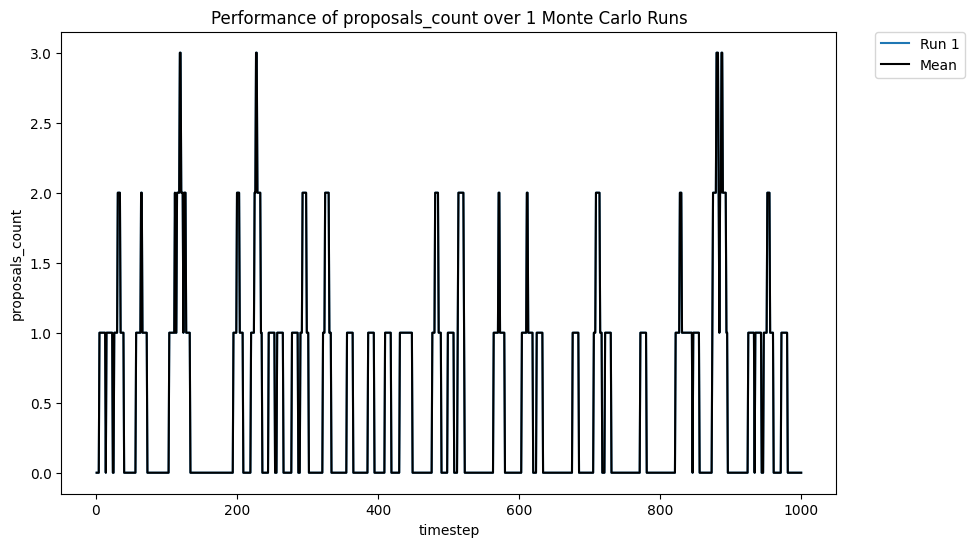

In [6]:
monte_carlo_plot(rdf, "timestep", "timestep", "proposals_count", 1)

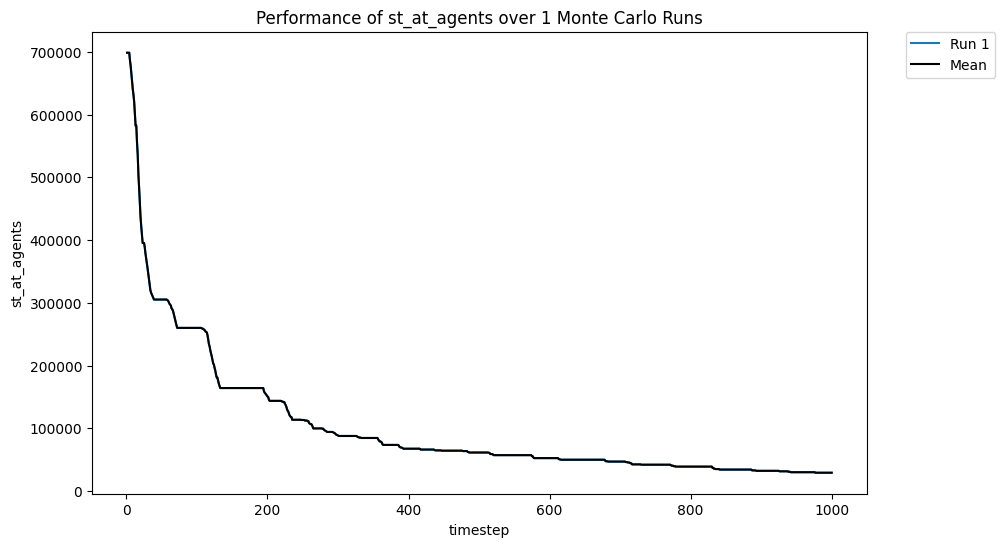

In [7]:
monte_carlo_plot(rdf, "timestep", "timestep", "st_at_agents", 1)

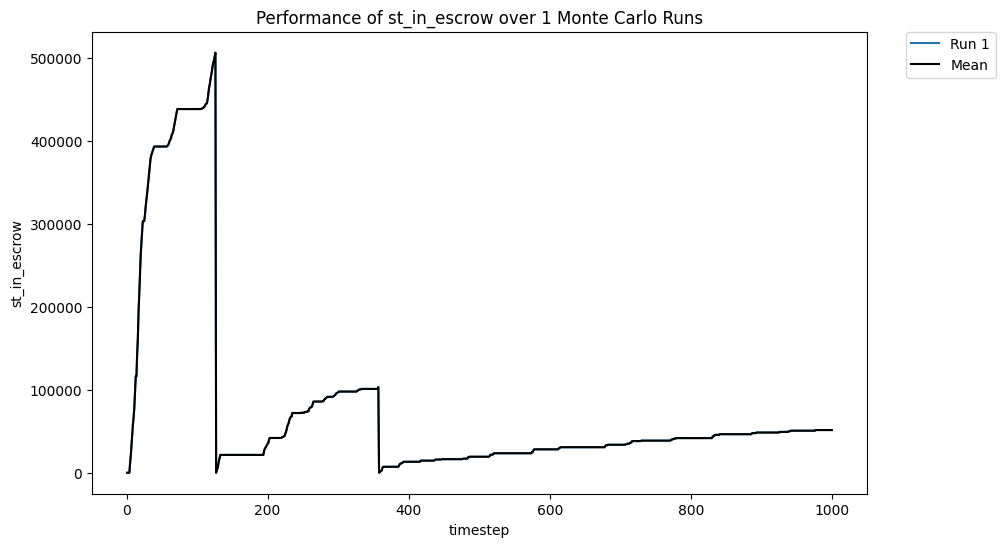

In [8]:
monte_carlo_plot(rdf, "timestep", "timestep", "st_in_escrow", 1)

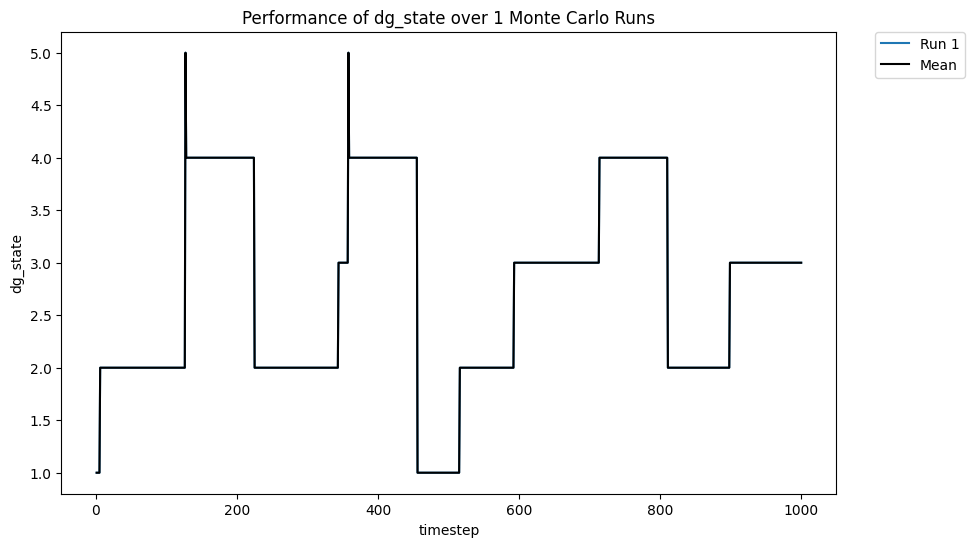

In [9]:
monte_carlo_plot(rdf, "timestep", "timestep", "dg_state", 1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


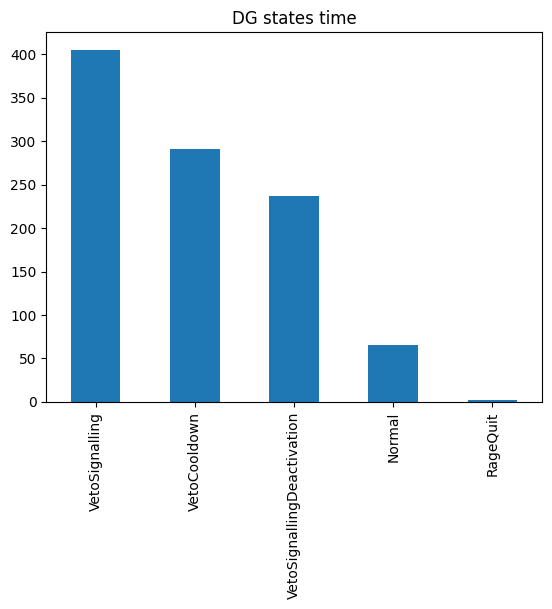

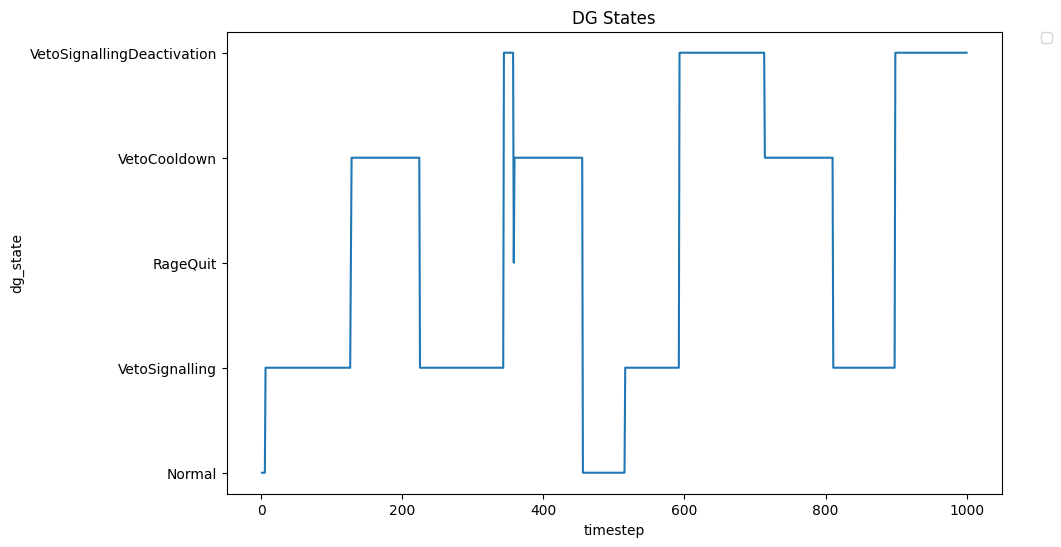

In [10]:
state_plot(rdf, "timestep", "dg_state", 1)

KeyError: 'dg_current_time'

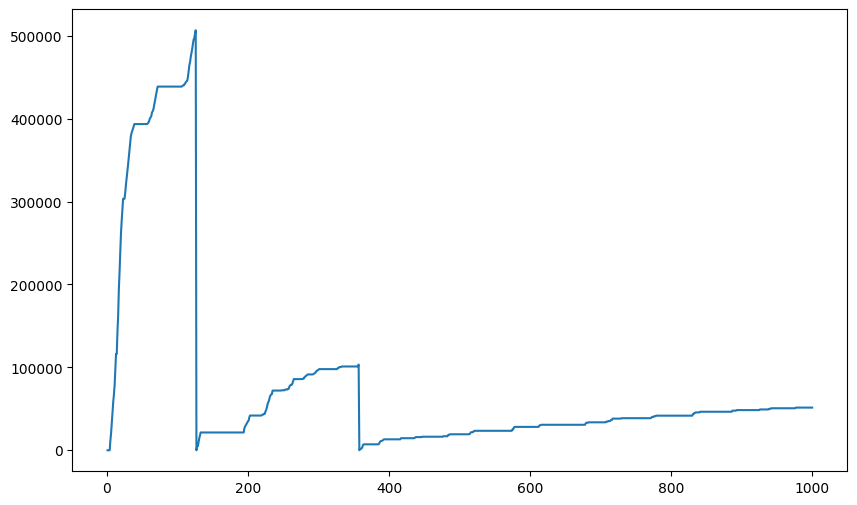

In [12]:
monte_carlo_plot(rdf, "timestep", "dg_current_time", "st_in_escrow", 1)